### Data Science Job Market: <i>Year 2020</i>

This project improves upon a previous data initiave by bringing in <i>updated data</i> to more precisely reflect current opportunities in the data science job market with the added variable of the ongoing COVID-19 global pandemic. Our goals include:
   * Determine the top 3 or top 10 technical skills that are in-demand for aspiring candidates
   * Deduce the hottest geographic areas that are doing high volume hiring in the data science space 
   * Summarize our observations and subsequent conclusions in a comprehensive jobs report which candidates can use as a <i>"ready-reckoner"</i> to make informed choices

#### Import Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from math import log10
from pywaffle import Waffle
from mycolorpy import colorlist as mcp
from collections import Counter

#### Data Preprocessing

<blockquote> Datasets were obtained from Kaggle and are separated by job functions <i>viz.,</i> data <i>analyst</i>, data <i>engineer</i> and data <i>scientist</i></blockquote>

In [2]:
# Set identifiers for the 3 CSV files
a_file = "Resources/data_analyst_jobs.csv"
e_file = "Resources/data_engineer_jobs.csv"
s_file = "Resources/data_scientist_jobs.csv"

In [3]:
# Read CSV files into respective dataframes 
analyst_df = pd.read_csv(a_file)
engineer_df = pd.read_csv(e_file)
scientist_df = pd.read_csv(s_file)

In [4]:
# Drop useless columns, rename them first
analyst_df.rename(columns={'Unnamed: 0': 'Nameless'}, inplace=True)
del analyst_df['Nameless']

scientist_df.rename(columns={'Unnamed: 0': 'Nameless'}, inplace=True)
del scientist_df['Nameless']

# Delete 'index' column from the data scientist jobs dataframe
del scientist_df['index']

<blockquote> Executive decisions were made to keep all data points for 
<i>engineering</i> roles since data engineers tend to wear many hats ranging from "tester"
to "architect". The engineering jobs mixed in with the other two job roles i.e., data 
analyst and data scientist were filtered out.</blockquote>

In [5]:
# Split values in 'Job Title' to create 'Job Category' that reflects the defined job function
engineer_df['Job Category'] = engineer_df['Job Title'].apply(lambda x: 'Data Engineer' if 'Engineer' in x else 'Data Engineer')
    
# Additionally, filter out engineering roles mixed in with analyst/scientist functions
analyst_df['Job Category'] = analyst_df['Job Title'].apply(lambda x: 'Data Analyst' if 'Analyst' in x else '')
scientist_df['Job Category'] = scientist_df['Job Title'].apply(lambda x: 'Data Scientist' if 'Scientist' in x else '')

In [6]:
# Combine the 3 dataframes into a single dataframe
datadf_list = [analyst_df, engineer_df, scientist_df]
datadf = pd.concat(datadf_list, join="inner")

<blockquote>The choice to drop the <i>Competitors</i> column from the combined dataframe stems from a reasoning that every aspiring candidate can do their own level of research about a Company and its competitors. From a very <i>practical</i> standpoint, we think this particular column is irrelevant to our objectives</blockquote>

In [7]:
# Drop the 'Competitors' column from the combined dataframe
del datadf['Competitors']

In [8]:
# Create a key-value mapping to rename columns
new_cols = {'Job Title':'Job Title', 'Job Category':'Job Type',
            'Salary Estimate':'Salary Range', 'Job Description':'Job Description',
            'Rating':'Job Rating', 'Company Name':'Company Name',
            'Location':'Location', 'Headquarters':'HQ',
            'Size':'Company Size',  'Founded':'Founded In',
            'Type of ownership':'Ownership Type', 'Industry':'Job Industry',
            'Sector':'Job Sector', 'Revenue':'Company Revenue','Easy Apply':'Easy Apply'}

# Rename all columns for the new dataframe
datadf_copy = datadf.copy()
datadf_copy.rename(columns=new_cols, inplace=True)

In [9]:
# Create a new dataframe containing all the data 
dsjobs_df = pd.DataFrame(datadf_copy, columns=['Job Title', 'Job Type',
                                          'Salary Range', 'Job Description',
                                          'Job Rating', 'Company Name',
                                          'Location', 'HQ', 'Company Size',
                                          'Founded In', 'Ownership Type',
                                          'Job Industry', 'Job Sector',
                                          'Company Revenue', 'Easy Apply'])

# Set the index for the new dataframe using the mapping
dsjobs_df.set_index(['Job Title'])

# Display first 5 records of the combined dataframe 
dsjobs_df.head()

,Job Title,Job Type,Salary Range,Job Description,Job Rating,Company Name,Location,HQ,Company Size,Founded In,Ownership Type,Job Industry,Job Sector,Company Revenue,Easy Apply
0,"Data Analyst, Center on Immigration and Justic...",Data Analyst,$37K-$66K (Glassdoor est.),Are you eager to roll up your sleeves and harn...,3.2,Vera Institute of Justice\n3.2,"New York, NY","New York, NY",201 to 500 employees,1961,Nonprofit Organization,Social Assistance,Non-Profit,$100 to $500 million (USD),True
1,Quality Data Analyst,Data Analyst,$37K-$66K (Glassdoor est.),Overview\n\nProvides analytical and technical ...,3.8,Visiting Nurse Service of New York\n3.8,"New York, NY","New York, NY",10000+ employees,1893,Nonprofit Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1
2,"Senior Data Analyst, Insights & Analytics Team...",Data Analyst,$37K-$66K (Glassdoor est.),We’re looking for a Senior Data Analyst who ha...,3.4,Squarespace\n3.4,"New York, NY","New York, NY",1001 to 5000 employees,2003,Company - Private,Internet,Information Technology,Unknown / Non-Applicable,-1
3,Data Analyst,Data Analyst,$37K-$66K (Glassdoor est.),Requisition NumberRR-0001939\nRemote:Yes\nWe c...,4.1,Celerity\n4.1,"New York, NY","McLean, VA",201 to 500 employees,2002,Subsidiary or Business Segment,IT Services,Information Technology,$50 to $100 million (USD),-1
4,Reporting Data Analyst,Data Analyst,$37K-$66K (Glassdoor est.),ABOUT FANDUEL GROUP\n\nFanDuel Group is a worl...,3.9,FanDuel\n3.9,"New York, NY","New York, NY",501 to 1000 employees,2009,Company - Private,Sports & Recreation,"Arts, Entertainment & Recreation",$100 to $500 million (USD),True


#### Data Transformation
<blockquote> This step involves operations such as handling missing values or values with '-1', dropping unwanted columns, creating new columns by splitting string values and finally splitting our main dataframe by type <i>viz.,</i> <b> positions, industry and location </b></blockquote>

##### Clean-up & Splitting Columns

In [10]:
# Clean up the 'Company Name' column to have relevant data 
company_names = dsjobs_df['Company Name'].str.split("\n", n=1, expand=True)
dsjobs_df['Company Name'] = company_names

# Split up 'Location' and 'HQ' into its respective City & State columns
jobs_city_state = dsjobs_df['Location'].str.split(", ", n=1, expand=True)
dsjobs_df['Location City'] = jobs_city_state[0]
dsjobs_df['Location State']= jobs_city_state[1]

hq_city_state = dsjobs_df['Location'].str.split(", ", n=1, expand=True)
dsjobs_df['HQ City'] = hq_city_state[0]
dsjobs_df['HQ State']= hq_city_state[1]

# Eliminate rows that do not have a uniform state code 
non_us_locs = ['Arapahoe, CO', 'United Kingdom']

dsjobs_df = dsjobs_df[~dsjobs_df['Location State'].isin(non_us_locs)]
dsjobs_df = dsjobs_df[~dsjobs_df['HQ State'].isin(non_us_locs)]

# Drop the 'Location' and 'HQ' columns that are no longer needed
del dsjobs_df['Location']
del dsjobs_df['HQ']

<blockquote> For the <i> Ownership Type </i> column, we transform the values to reflect single word entries to make our work easier</blockquote>

In [11]:
# Create a key-value mapping to rename all values in 'Ownership Type' column
ownership_dict = {'Nonprofit Organization':'Non-Profit', 'Company - Private':'Private',
                  'Subsidiary or Business Segment':'Subsidiary', 'Company - Public':'Public', 
                  'Hospital':'Hospital', 'Contract':'Contracted', 'Government':'Government',
                  'School / School District':'School', 'Other Organization':'Other',
                  'College / University':'University', 'Self-employed':'Freelance', 
                  'Private Practice / Firm':'Firm', 'Franchise':'Franchise'}

# Replace all the values with relevant strings using the mapping
dsjobs_df = dsjobs_df.replace({"Ownership Type": ownership_dict})

<blockquote> For the <i>Easy Apply</i> column, we make assumptions that '-1' indicates a falsity since not enough information is available to classify it under any other categories </blockquote>

In [12]:
# Replace all '-1' values in 'Easy Apply' with False 
easy_apply_dict = {'-1':False}
dsjobs_df = dsjobs_df.replace({"Easy Apply": easy_apply_dict})

##### Forming regular expressions to handle range values
<blockquote> For the columns named <i>'Salary Range', 'Company Size' and 'Company Revenue'</i> we will form custom regular expressions to transform them into intuitive labels</blockquote>

In [13]:
# Use regex to extract substring to be used as replacement for values in 'Salary Range' column
dsjobs_df['Salary Range'] = dsjobs_df['Salary Range'].str.extract("(?<!\S)(\$[0-9]{2,3}K\-\$[0-9]{2,3}K)", expand=True)

# Use string splitting to transform values in 'Company Size' column 
dsjobs_df['Company Size'] = dsjobs_df['Company Size'].str.split(" e", n=1, expand=True)
dsjobs_df['Company Size'] = dsjobs_df['Company Size'].str.strip()

In [14]:
# Use regex & string replace methods to transform values in 'Company Revenue' column 
dsjobs_df['Company Revenue'] = dsjobs_df['Company Revenue'].str.replace(" to ", "-")
dsjobs_df['Company Revenue'] = dsjobs_df['Company Revenue'].str.replace(" million", "M")
dsjobs_df['Company Revenue'] = dsjobs_df['Company Revenue'].str.replace(" billion", "B")

dsjobs_df['Company Revenue'] = dsjobs_df['Company Revenue'].str.split(' ', n=1, expand=True)
dsjobs_df['Company Revenue'] = dsjobs_df['Company Revenue'].str.strip()

##### Eliminating rows with missing or unknown values
<blockquote> The choice to eliminate missing or null values is justified in the objective of narrowing down the job search to those positions from which we can derive the most information. After all, <i>"little knowledge is dangerous!"</i></blockquote>

In [15]:
# Create a list that contains all types of outlier data observed in the final dataframe
all_other_vals = {'-1', 'Unknown', -1, '', 'Less'}

# Eliminate rows that have missing or unknown values
dsjobs_df = dsjobs_df[~dsjobs_df.isin(all_other_vals)]

# Eliminating any other null values in specific columns
dsjobs_df = dsjobs_df.dropna(axis=0)

In [16]:
dsjobs_df.head()

,Job Title,Job Type,Salary Range,Job Description,Job Rating,Company Name,Company Size,Founded In,Ownership Type,Job Industry,Job Sector,Company Revenue,Easy Apply,Location City,Location State,HQ City,HQ State
0,"Data Analyst, Center on Immigration and Justic...",Data Analyst,$37K-$66K,Are you eager to roll up your sleeves and harn...,3.2,Vera Institute of Justice,201 to 500,1961.0,Non-Profit,Social Assistance,Non-Profit,$100-$500M,True,New York,NY,New York,NY
1,Quality Data Analyst,Data Analyst,$37K-$66K,Overview\n\nProvides analytical and technical ...,3.8,Visiting Nurse Service of New York,10000+,1893.0,Non-Profit,Health Care Services & Hospitals,Health Care,$2-$5B,False,New York,NY,New York,NY
3,Data Analyst,Data Analyst,$37K-$66K,Requisition NumberRR-0001939\nRemote:Yes\nWe c...,4.1,Celerity,201 to 500,2002.0,Subsidiary,IT Services,Information Technology,$50-$100M,False,New York,NY,New York,NY
4,Reporting Data Analyst,Data Analyst,$37K-$66K,ABOUT FANDUEL GROUP\n\nFanDuel Group is a worl...,3.9,FanDuel,501 to 1000,2009.0,Private,Sports & Recreation,"Arts, Entertainment & Recreation",$100-$500M,True,New York,NY,New York,NY
7,Data Science Analyst,Data Analyst,$37K-$66K,Data Science Analyst\n\nJob Details\nLevel\nEx...,3.7,GNY Insurance Companies,201 to 500,1914.0,Private,Insurance Carriers,Insurance,$100-$500M,True,New York,NY,New York,NY


In [17]:
dsjobs_df.shape

(3532, 17)

##### Preparing custom dataframes for plotting
<blockquote> Once all transformations are completed, we set about making custom dataframes with only <i> certain </i> columns that will serve our purposes for further analysis</blockquote>

In [18]:
# Create a dataframe with job-specific columns
jobs_df = pd.DataFrame(dsjobs_df, columns=['Job Title', 'Job Type', 'Job Description',
                                           'Salary Range', 'Job Rating', 'Job Industry',
                                           'Job Sector', 'Easy Apply'])

jobs_df.set_index(['Job Title'])
jobs_df.head()

,Job Title,Job Type,Job Description,Salary Range,Job Rating,Job Industry,Job Sector,Easy Apply
0,"Data Analyst, Center on Immigration and Justic...",Data Analyst,Are you eager to roll up your sleeves and harn...,$37K-$66K,3.2,Social Assistance,Non-Profit,True
1,Quality Data Analyst,Data Analyst,Overview\n\nProvides analytical and technical ...,$37K-$66K,3.8,Health Care Services & Hospitals,Health Care,False
3,Data Analyst,Data Analyst,Requisition NumberRR-0001939\nRemote:Yes\nWe c...,$37K-$66K,4.1,IT Services,Information Technology,False
4,Reporting Data Analyst,Data Analyst,ABOUT FANDUEL GROUP\n\nFanDuel Group is a worl...,$37K-$66K,3.9,Sports & Recreation,"Arts, Entertainment & Recreation",True
7,Data Science Analyst,Data Analyst,Data Science Analyst\n\nJob Details\nLevel\nEx...,$37K-$66K,3.7,Insurance Carriers,Insurance,True


In [19]:
# Create a dataframe with company-specific columns
company_df = pd.DataFrame(dsjobs_df, columns=['Job Title', 'Company Name', 'Salary Range',
                                              'Company Size', 'Founded In', 'Ownership Type',
                                              'Company Revenue'])

company_df.set_index(['Job Title'])
company_df.head()

,Job Title,Company Name,Salary Range,Company Size,Founded In,Ownership Type,Company Revenue
0,"Data Analyst, Center on Immigration and Justic...",Vera Institute of Justice,$37K-$66K,201 to 500,1961.0,Non-Profit,$100-$500M
1,Quality Data Analyst,Visiting Nurse Service of New York,$37K-$66K,10000+,1893.0,Non-Profit,$2-$5B
3,Data Analyst,Celerity,$37K-$66K,201 to 500,2002.0,Subsidiary,$50-$100M
4,Reporting Data Analyst,FanDuel,$37K-$66K,501 to 1000,2009.0,Private,$100-$500M
7,Data Science Analyst,GNY Insurance Companies,$37K-$66K,201 to 500,1914.0,Private,$100-$500M


In [20]:
# Create a dataframe with location-specific columns
location_df = pd.DataFrame(dsjobs_df, columns=['Job Title', 'Company Name', 'Salary Range',
                                               'Location City', 'Location State', 'HQ City', 'HQ State'])

location_df.set_index(['Job Title'])
location_df.head()

,Job Title,Company Name,Salary Range,Location City,Location State,HQ City,HQ State
0,"Data Analyst, Center on Immigration and Justic...",Vera Institute of Justice,$37K-$66K,New York,NY,New York,NY
1,Quality Data Analyst,Visiting Nurse Service of New York,$37K-$66K,New York,NY,New York,NY
3,Data Analyst,Celerity,$37K-$66K,New York,NY,New York,NY
4,Reporting Data Analyst,FanDuel,$37K-$66K,New York,NY,New York,NY
7,Data Science Analyst,GNY Insurance Companies,$37K-$66K,New York,NY,New York,NY


#### Data Analysis & Visualization
<blockquote> This step involves working with individual dataframes to perform analyses, spot correlations between different columns in the data and visualize our analysis by way of different plots, charts and mappings. </blockquote>

##### Row Chart to Visualize the Percent of Job Postings by Job Role (i.e., engineer, analyst and scientist)

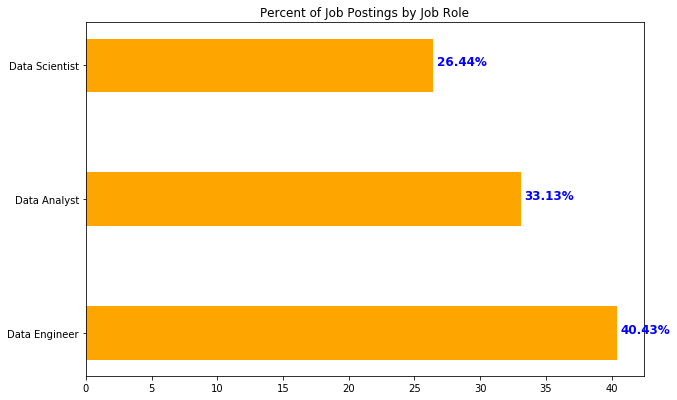

In [21]:
# Get the number of job postings by the job type 
jobs_count_by_type = jobs_df['Job Type'].value_counts()
jobs_count_dict = jobs_count_by_type.to_dict()

# Separate the job counts and job types into two lists
job_types = list(jobs_count_dict.keys())
jobs_counts = list(jobs_count_dict.values())

# Get percentages for the job counts by job type
total_job_counts = sum(jobs_counts)

job_count_percents = [(c / total_job_counts) * 100 for c in jobs_counts]
job_count_percents = [round(val, 2) for val in job_count_percents]

# Plot the percent of job postings by job type on a horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 6.5))
width=0.40
ax.barh(job_types, job_count_percents, width, color='orange')
ax.set_title('Percent of Job Postings by Job Role')

for i, v in enumerate(job_count_percents):
    ax.text(v + 0.25, i, str(v)+'%',
            color = 'blue', fontweight = 'bold', fontsize=12)

##### Stacked Row Chart to Visualize the Proportion of Jobs Available for Easy Apply

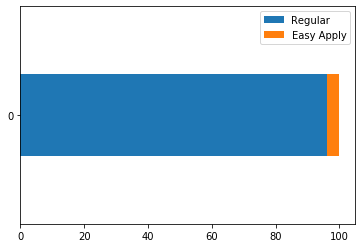

In [22]:
# Get the number of job postings that have 'Easy Apply' option
jobs_by_easy_apply = jobs_df['Easy Apply'].value_counts()
jobs_easy_apply_dict = jobs_by_easy_apply.to_dict()

# Transform 'True' and 'False' cateogories into intuitive labels
jobs_easy_apply_dict['Regular'] = jobs_easy_apply_dict.pop(False)
jobs_easy_apply_dict['Easy Apply'] = jobs_easy_apply_dict.pop('True')

# Separate the job counts and job types into two lists
job_categories = list(jobs_easy_apply_dict.keys())
jobs_counts = list(jobs_easy_apply_dict.values())

# Get percentages for the job counts by job type
total_job_counts = sum(jobs_counts)

easy_apply_percents = [(c / total_job_counts) * 100 for c in jobs_counts]
easy_apply_percents_list = [round(val) for val in easy_apply_percents]

easy_apply_percents_dict = {}
easy_apply_percents_dict['Regular'] = easy_apply_percents_list[0]
easy_apply_percents_dict['Easy Apply'] = easy_apply_percents_list[1]

# Convert the newly created dictionary into a series for plotting
easy_apply_percents_df = pd.Series(easy_apply_percents_dict)

# Plot a horizontal stacked bar chart to show proportion of jobs that are 'Easy Apply'
easy_apply_percents_df.to_frame().T.plot.barh(stacked=True, width=0.30)

##### Pie Chart to Visualize the Top 10 Job Sectors by Job Postings

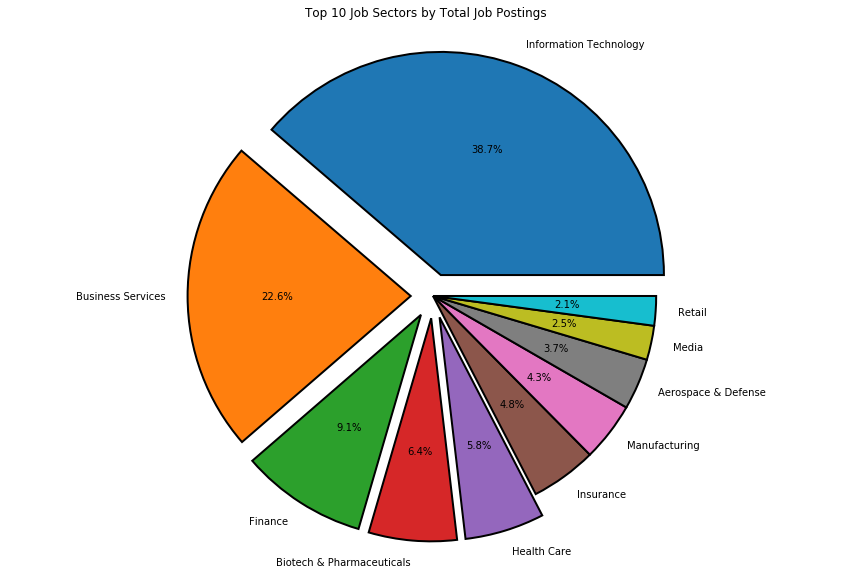

In [23]:
# Get the number of job postings categorized by Job Sector
jobs_by_sector = jobs_df['Job Sector'].value_counts()
jobs_by_sector_dict = jobs_by_sector.to_dict()

jobs_by_sector_top_10 = dict(Counter(jobs_by_sector_dict).most_common(10))

# Separate the job sector labels and job counts as lists
job_sectors = list(jobs_by_sector_top_10.keys())
job_counts = list(jobs_by_sector_top_10.values())

# Plot a pie chart to deduce the Top 10 Job Sectors doing the most hiring
colors = mcp.gen_color('tab10', n=10)
explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0, 0, 0, 0, 0) 
  
plt.pie(job_counts, colors=colors, explode=explode, labels=job_sectors,
        autopct = '%1.1f%%',startangle = 0,
        wedgeprops = {"edgecolor" : "black",
                    'linewidth' : 2,
                    'antialiased': True})

fig = plt.gcf()
fig.set_figwidth(15)
fig.set_figheight(10)

plt.title('Top 10 Job Sectors by Total Job Postings')
  
# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal') 
  
plt.show()

##### Bar Chart to Visualize the Average Job Rating per Job Type (i.e, analyst, engineer and scientist)

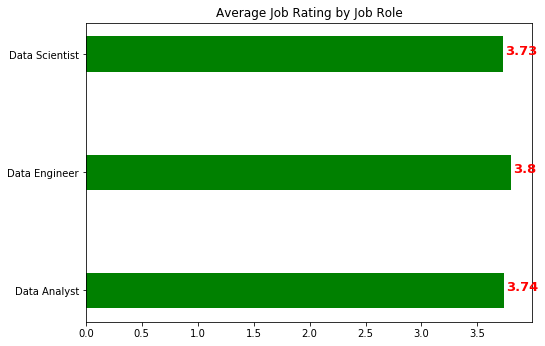

In [24]:
# Get the average job rating per job type 
avg_job_ratings = jobs_df.groupby('Job Type')['Job Rating'].mean()
avg_job_ratings_dict = avg_job_ratings.to_dict()

# Separate the job type and job ratings as lists
job_type = list(avg_job_ratings_dict.keys())
job_ratings = list(avg_job_ratings_dict.values())

job_ratings = [round(val, 2) for val in job_ratings]

# Plot the average job ratings by job type on a bar chart
fig, ax = plt.subplots(figsize=(8, 5.5))
width=0.30
ax.barh(job_type, job_ratings, width, color='green')
ax.set_title('Average Job Rating by Job Role')

for i, v in enumerate(job_ratings):
    ax.text(v + 0.02, i, str(v),
            color = 'red', fontweight = 'bold', fontsize=13)

##### Waffle Chart to Visualize the Volumne of Hiring by Company Size

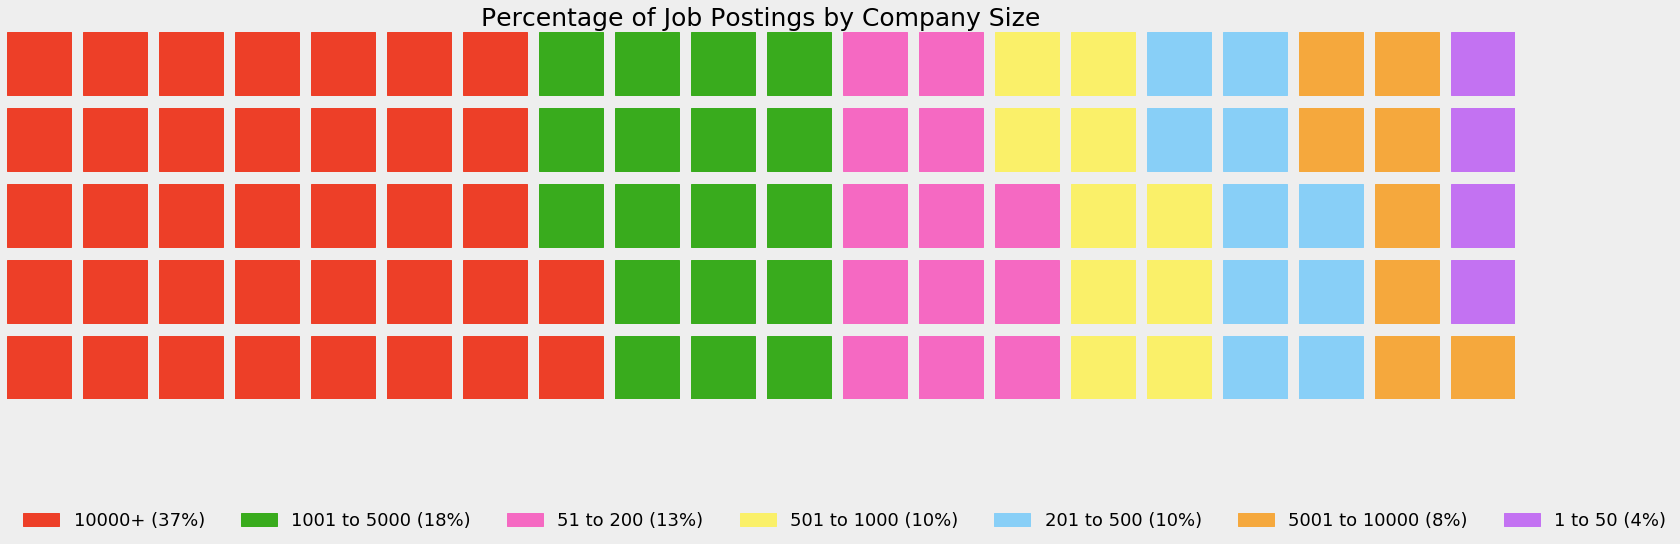

In [25]:
# Get the number of job postings by company size (or number of employees per company)
jobs_by_company_size = company_df['Company Size'].value_counts()
jobs_by_company_size_dict = jobs_by_company_size.to_dict()

# Separate the job counts and company size into two lists
company_size = list(jobs_by_company_size_dict.keys())
job_counts = list(jobs_by_company_size_dict.values())

# Get percentages for the job counts by job type
total_job_counts = sum(jobs_counts)

job_count_percents = [(c / total_job_counts) * 100 for c in job_counts]
job_count_percents_list = [round(val) for val in job_count_percents]

job_counts_company_size = dict(zip(company_size, job_count_percents_list))

# Plot a waffle chart indicating the percentage of job postings with 'Easy Apply'
fig = plt.figure(
    FigureClass=Waffle, 
    rows=5, 
    values=job_count_percents_list, 
    colors=("#ED3F28", "#39AB1D", "#F569C2", "#FAF069", "#88CFF7", "#F5A83D", "#C372F2"),
    title={'label': 'Percentage of Job Postings by Company Size', 'loc': 'center', 'fontsize': 25},
    labels=["{0} ({1}%)".format(k, v) for k, v in job_counts_company_size.items()],
    legend={'loc': 'lower left', 'bbox_to_anchor': (0, -0.4), 'ncol': len(job_counts_company_size), 'framealpha': 0, 'fontsize': 18}
)
fig.set_figwidth(25)
fig.set_figheight(15)
fig.gca().set_facecolor('#EEEEEE')
fig.set_facecolor('#EEEEEE')
plt.show()

In [26]:
company_df['Company Revenue'].unique()

array(['$100-$500M', '$2-$5B', '$50-$100M', '$1-$2B', '$5-$10B', '$1-$5M',
       '$25-$50M', '$10+B', '$10-$25M', '$500M-$1B', '$5-$10M'],
      dtype=object)

##### Donut Pie Chart to Visualize Total Number of Companies by Company Revenue

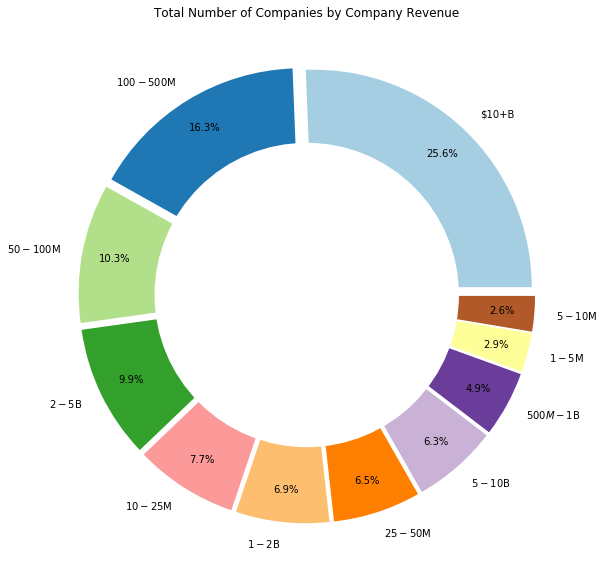

In [27]:
# Get the total number of companies grouped by size of Company Revenue
total_companies_by_revenue = company_df['Company Revenue'].value_counts()
total_companies_by_revenue_dict = total_companies_by_revenue.to_dict()

# Separate the company counts and company revenue into two lists
company_revenues = list(total_companies_by_revenue_dict.keys())
company_counts = list(total_companies_by_revenue_dict.values())

# Plot a donut pie chart to visualize total companies by company revenue size
colors = mcp.gen_color(cmap='Paired', n=11)
explode = [0.05] * 11

plt.pie(company_counts, colors=colors, labels=company_revenues,
        autopct='%1.1f%%', pctdistance=0.85,
        explode=explode)
  
centre_circle = plt.Circle((0, 0), 0.70, fc='white')

fig = plt.gcf()
fig.set_figwidth(15)
fig.set_figheight(10)
fig.gca().add_artist(centre_circle)

plt.title('Total Number of Companies by Company Revenue')
plt.show()